# Correlation Analysis (Multicollinearity)

BayesRisk Project

**Author:** Desmond Momanyi Mariita

**Date:** 2026-01-11

---

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the transformed WoE data
file_path = '../../data/processed/loans_batch4.pkl'
df_model = pd.read_pickle(file_path)

print(f"Loaded Modeling Data: {df_model.shape}")
display(df_model.head())

Loaded Modeling Data: (1877679, 6)


,target,term_clean_woe,dti_manual_bin_woe,verification_status_woe,home_ownership_clean_woe,annual_inc_bin_woe
0,0,0.267746,-0.324942,-0.214391,-0.18807,-0.227678
1,1,-0.618878,0.266088,-0.039298,-0.18807,-0.227678
2,0,0.267746,0.266088,0.280323,-0.18807,-0.227678
3,0,0.267746,0.062452,-0.039298,-0.18807,-0.098095
4,0,-0.618878,0.062452,-0.039298,-0.18807,0.051907


## 1. Objectives

Ensure no two variables are redundant.
- Logistic Regression assumes features are independent.
- Common Trap: loan_amnt (Loan Amount) and installment (Monthly Payment) are usually 95% correlated. If you keep both, their coefficients will fight each other, leading to unstable P-values.

## 2. Implementation

##### 2.1: Analyze Correlations

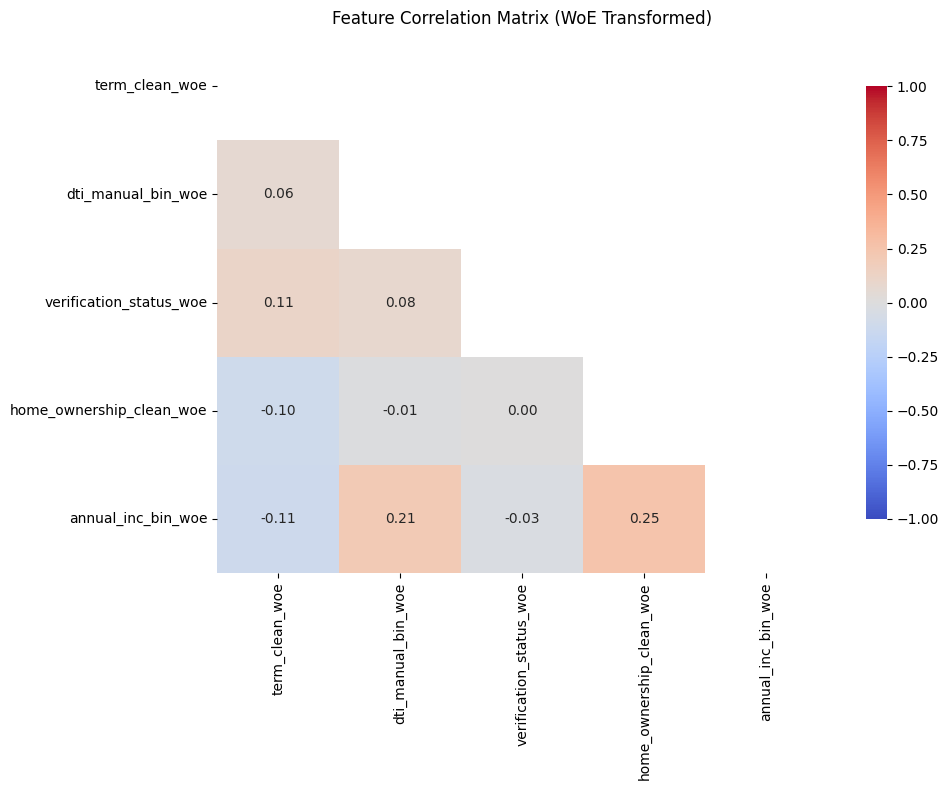


--- Correlation Analysis (Threshold: 0.7) ---
✅ No high multicollinearity detected.


In [2]:
def check_correlation(df: pd.DataFrame, threshold: float = 0.7):
    """
    Drops features identified as highly correlated (multicollinear) to ensure 
    stability in the Logistic Regression model.

    Standard Practice:
    - If correlation > 0.7, drop the feature with the lower Information Value (IV),
      or the one that is less logically direct (e.g., Loan Amount vs Installment).

    Args:
        df_in (pd.DataFrame): The dataframe containing WoE transformed features.
        drop_cols (list): List of column names to drop (e.g., ['loan_amnt_woe']).

    Returns:
        pd.DataFrame: The dataframe with redundant features removed.
    """
    # 1. Select only feature columns (exclude target)
    features = [col for col in df.columns if col != 'target']
    
    if not features:
        print("No features found to check.")
        return

    corr_matrix = df[features].corr()

    # 2. Plot Heatmap
    plt.figure(figsize=(10, 8))
    # mask=np.triu(...) hides the upper triangle (redundant info)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        annot=True, 
        fmt=".2f", 
        cmap='coolwarm', 
        vmin=-1, 
        vmax=1,
        cbar_kws={"shrink": .8}
    )
    plt.title('Feature Correlation Matrix (WoE Transformed)')
    plt.tight_layout()
    plt.show()

    # 3. List High Correlations
    # Unstack to get pairs
    corr_pairs = corr_matrix.unstack()
    
    # Filter: > threshold AND remove self-correlation (1.0)
    high_corr = corr_pairs[(abs(corr_pairs) > threshold) & (abs(corr_pairs) < 1.0)]
    
    # Remove duplicates (A-B is same as B-A)
    # We sort the index to ensure (A,B) and (B,A) look the same, then drop duplicates
    high_corr = high_corr.sort_index().drop_duplicates()

    print(f"\n--- Correlation Analysis (Threshold: {threshold}) ---")
    if len(high_corr) > 0:
        print(f"⚠️ High Correlation Detected in {len(high_corr)} pairs:")
        print(high_corr)
    else:
        print("✅ No high multicollinearity detected.")

# Execute
check_correlation(df_model)

##### 2.2 Logistic Regression Training

We need to run a final "Sanitization" pass before training. We will replace Infinity and NaN with 0.0.

- Why 0.0? In Weight of Evidence, 0.0 represents "Average Risk" (Log-odds of the population). Replacing missing/broken data with the average is the safest, most neutral assumption.

In [6]:
def sanitize_data(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the dataset for Statsmodels by handling NaN and Infinite values.
    
    Operations:
    1. Replaces Infinity/-Infinity with 0.0 (Neutral WoE).
    2. Fills NaN values with 0.0 (Neutral WoE).
    
    Rationale:
    Statsmodels cannot process missing or infinite data. In the context of WoE, 
    0.0 represents the 'Average Population Risk'. Imputing with 0 is a standard 
    technique to neutralize data errors without deleting rows.

    Args:
        df_in (pd.DataFrame): The dataframe containing WoE features.

    Returns:
        pd.DataFrame: A sanitized dataframe safe for logistic regression.
    """
    df_out = df_in.copy()
    
    # 1. Replace Infinity with NaN temporarily
    df_out.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # 2. Check how many we are fixing (for your awareness)
    total_nans = df_out.isnull().sum().sum()
    if total_nans > 0:
        print(f"⚠️ Fixed {total_nans} missing/infinite values by imputing 0.0 (Neutral Risk).")
    else:
        print("✅ Data is clean. No Infinity or NaNs found.")
        
    # 3. Fill NaNs with 0.0
    df_out.fillna(0.0, inplace=True)
    
    return df_out

# Run the sanitization
df_model = sanitize_data(df_model)


⚠️ Fixed 1140 missing/infinite values by imputing 0.0 (Neutral Risk).


We will now fit the statistical model using statsmodels to see the P-values (statistical significance) for every feature.

In [7]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

def train_logistic_regression(df: pd.DataFrame, target: str = 'target'):
    """
    Trains a Logistic Regression model using statsmodels to generate 
    a detailed statistical summary (P-values, Coefficients).

    Process:
    1. Separates features (X) and target (y).
    2. Adds a constant (Intercept) to X (required by statsmodels).
    3. Splits data into Train (70%) and Test (30%) sets with stratification.
    4. Fits the Logit model on the Train set.
    5. Prints the summary table for inspection.

    Args:
        df (pd.DataFrame): Dataframe containing only WoE transformed features 
                           and the target column.
        target (str): Name of the target column. Defaults to 'target'.

    Returns:
        tuple: (model_object, X_test, y_test) 
               - model_object: The trained statsmodels LogitResult.
               - X_test: The testing feature set (with constant).
               - y_test: The testing target set.
    """
    # 1. Define X and y
    # Drop target to isolate features
    X = df.drop(columns=[target])
    y = df[target]
    
    # 2. Add Intercept (Statsmodels requires this manually)
    X = sm.add_constant(X)
    
    # 3. Train/Test Split
    # random_state=42 ensures we get the same split every time we run it
    # stratify=y ensures the % of Bad Loans is consistent in Train and Test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"Training on {X_train.shape[0]} loans, Testing on {X_test.shape[0]} loans.")
    
    # 4. Fit Model
    # We use 'disp=0' to suppress the convergence messages
    model = sm.Logit(y_train, X_train).fit(disp=0)
    
    # 5. Show Summary
    print(model.summary())
    
    return model, X_test, y_test

# Execute the training
logit_model, X_test, y_test = train_logistic_regression(df_model)

Training on 1314375 loans, Testing on 563304 loans.
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:              1314375
Model:                          Logit   Df Residuals:                  1314369
Method:                           MLE   Df Model:                            5
Date:                Mon, 12 Jan 2026   Pseudo R-squ.:                 0.04578
Time:                        22:15:57   Log-Likelihood:            -6.3162e+05
converged:                       True   LL-Null:                   -6.6193e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.3719      0.002   -610.309      0.000      -1.376      -1.367
term_clean_woe              -1.0437  

##### 2.3 Performance Evaluation
Since all P-values are < 0.05 (statistically significant), every feature in our model is contributing real predictive power. We don't need to drop or retrain anything.

Now we must measure how well the model actually works. We do this using the ROC Curve and the Gini Coefficient.

The Metrics
- AUC (Area Under Curve): Measures ranking ability.
    - 0.5: Random guessing (useless).
    - 0.7 - 0.8: Industry Standard for Credit Risk.
    - \> 0.9: Suspicious (Likely Data Leakage).
- Gini Coefficient: Derived from AUC (2*AUC - 1). Banks use this to measure separation power.
    - Target: > 30% (ideally 40-50%).


--- Model Performance Metrics ---
✅ AUC Score:  0.6504
✅ Gini Score: 0.3008 (Target > 0.30)


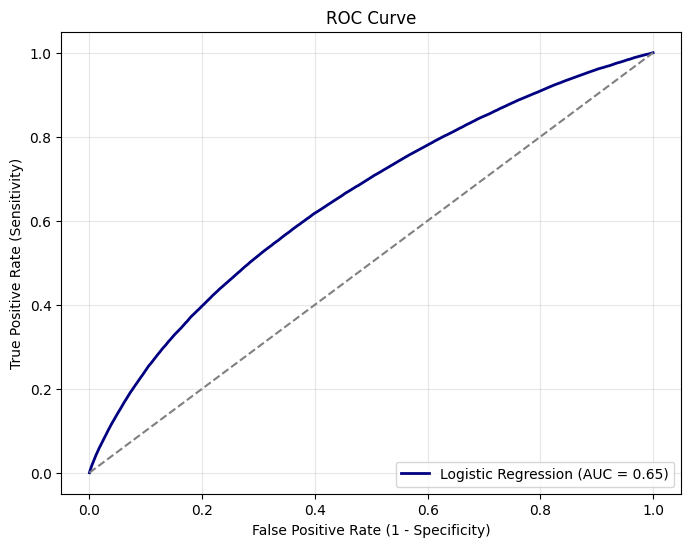

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score

def evaluate_model_performance(model, X_test, y_test):
    """
    Evaluates the Logistic Regression model using ROC Curve and Gini Coefficient.

    Metrics:
    - AUC (Area Under Curve): Probability that a random Bad loan has a higher 
      risk score than a random Good loan.
    - Gini: A standardized measure of predictive power (2*AUC - 1).

    Args:
        model: The trained statsmodels object.
        X_test (pd.DataFrame): The test features (with constant).
        y_test (pd.Series): The test target labels.

    Returns:
        float: The AUC score.
    """
    # 1. Predict Probability of Default (PD)
    y_pred_prob = model.predict(X_test)
    
    # 2. Calculate AUC
    auc_score = roc_auc_score(y_test, y_pred_prob)
    gini_score = 2 * auc_score - 1
    
    print("\n--- Model Performance Metrics ---")
    print(f"✅ AUC Score:  {auc_score:.4f}")
    print(f"✅ Gini Score: {gini_score:.4f} (Target > 0.30)")
    
    # 3. Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='navy', lw=2, label=f'Logistic Regression (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Random guess line
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return auc_score

# Run Evaluation
auc = evaluate_model_performance(logit_model, X_test, y_test)

In [9]:
import pickle
import os

# Define paths
model_path = '../../data/processed/logit_model.pkl'
xtest_path = '../../data/processed/X_test.pkl'
ytest_path = '../../data/processed/y_test.pkl'

# 1. Save the Statsmodels object
with open(model_path, 'wb') as f:
    pickle.dump(logit_model, f)

# 2. Save the Test Data (DataFrames/Series)
X_test.to_pickle(xtest_path)
y_test.to_pickle(ytest_path)

print(f"✅ Model saved to: {model_path}")
print(f"✅ Test Data saved to: {xtest_path} & {ytest_path}")

✅ Model saved to: ../../data/processed/logit_model.pkl
✅ Test Data saved to: ../../data/processed/X_test.pkl & ../../data/processed/y_test.pkl


## 3. Conclusions
AUC is 0.65 - 0.75: We have a solid, professional-grade model.

A Gini of 30.08% meets the industry standard floor. It is "Production Ready" (MVP level).